# Lab 5

**Joseph Livesey**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal
import pickle

plt.rcParams['figure.figsize'] = (15, 10)

In this lab, we will be looking at a training set of data from the Higgs boson experiment at the Large Hadron Collider (LHC). First, we load in our data. The data in `higgs` represent a signal—a possible detection of a Higgs boson by the LHC calorimeter. The data in `qcd` are the background distribution due to quantum chromodynamical effects that are prominent at low energy scales.

In [3]:
dicts = []

for pkl in ['higgs_100000_pt_250_500.pkl', 'qcd_100000_pt_250_500.pkl']:
    file = open(pkl, 'rb')
    data = pickle.load(file)
    dicts.append(data)

higgs = dicts[0]
qcd   = dicts[1]

In [4]:
higgs.keys(), qcd.keys()

(Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
        't2', 't3', 't21', 't32', 'KtDeltaR'],
       dtype='object'),
 Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
        't2', 't3', 't21', 't32', 'KtDeltaR'],
       dtype='object'))

The data we're working with are derived from the ATLAS detector at the LHC. In this experiment, proton-proton collisions are facilitated at the center of the detector. This collision results in a long decay chain that may contain the decay $H \to b\bar{b}$ (Higgs boson becomes a bottom quark and an anti-bottom quark). Such a decay chain is deemed a **Higgs jet**, distinguishing from other jets that come about as a result of a collision. Each collision produces "jets" of particles that progress through a chain of decays until they strike the ATLAS detector. In order to identify Higgs jets, it is imperative to understand the internal structures of jets.

In this experiment, proton-proton collisions were facilitated with a **center-of-mass energy** $\sqrt{s} = 13 \text{ TeV}$, far exceeding previous LHC Higgs experiments that used $\sqrt{s} \simeq 7 \text{ TeV}$. The center-of-mass energy is in essence just the total energy that goes toward making new particles in the laboratory reference frame. The higher value of $\sqrt{s}$ extends the sensitivity of the experiment relative to its predecessors. The detector itself encompasses a large volume with the collision point roughly at the center, and envelops almost the entire solid angle around the collision.

There are two triggers that enable the identification of relevant signals. The first-level trigger is in the hardware, selecting a subset of detections to keep the rate of data collection at about 100,000 detections per second. The second-level trigger is in the software, which identifies detections of interest from these and further reduces the rate to about 1,000 detections per second.

Non-Higgs signals appear in the data due to "parton scattering" in the particle showers that result from $pp$-collisions. The decay $g \to b\bar{b}$ (initial state is a gluon instead of a Higgs boson) results from this, and our primary objective is to discriminate between jets that come about as a result of this **QCD background** and real Higgs jets. The simulated QCD background we will concern ourselves with is contained within the `qcd` dataset.

The keys here mostly refer to elements of what is known as the **jet substructure**. Jets are produced by particle interactions, and the energies of these jets are what is detected by ATLAS. Jets are not simply particles that result from some decay flying until they strike the detector. They are complicated objects with an internal structure that can be characterized through the data collected by ATLAS. Jet substructure is a collection of observable quantities that are dependent on the energy flow within an individual jet.

The first order of business in this lab is to understand what each of the keys in these datasets represent. So, let's go through them one by one.

* `pt` refers to $p_T$, the **transverse momentum** of the particle in question. The transverse momentum is the component of the particle's momentum in the lab frame perpendicular to the beamline. This is important because, on average, incident particles have zero transverse momentum. So, if an interaction occurs in the detector, nonzero $p_T$ is an indicator of this.

* `eta` refers to the parameter $\eta$, which is the **pseudorapidity** of the jet. The pseudorapidity can be calculated from $\eta = -\ln \tan (\theta/2)$, where $\theta$ is the polar angle (the direction $\theta = 0$ is orthogonal to the beam pipe, while $\theta = \pi/2$ corresponds to the axis of the beam pipe).

* `phi` refers to the parameter $\phi$, which is the azimuthal angle of the site at which a jet is detected on the detector.

* `mass`, as one would expect, refers to the mass of the jet.

* `d2` refers to $D_2^{\beta=1}$, which can be calculated from **energy correlation functions**. This is useful as a discriminating variable to tell "two-pronged" from "three-pronged" decays. $E_{\text{CF}i}$ represents the $i$-th energy correlation function. The relationship is

$$ D_2^{\beta=1} = E_{\text{CF}3} \left ( \frac{E_{\text{CF}1}}{E_{\text{CF}2}} \right )^3. $$

* `ee2` is the value of the two-point energy correlation function, $E_\text{CF2}$, which identifies "two-pronged" jets.

* `ee3` is the value of the three-point energy correlation function, $E_\text{CF3}$, which identifies "three-pronged" jets.

* `angularity` is angularity, as the name would imply. The **jet angularity** is a sum over the 4-momenta of particles in a jet, weighted by their respective $p_T$.

* `t1`, `t2`, and `t3` refer to a parameter called $\tau_n$. This is the $n$**-subjettiness** of the jet substructure. The $n$-subjettiness is a parameter related to the "jet shape", and is used as a discriminating variable to identify jets resulting from different decays.

* `t21` and `t32` refer to $\tau_{ij}$, where $\tau_{ij} \equiv \tau_i/\tau_j$. This ratio is effective in identifying different particles from their decays. In particular, $\tau_{21}$ is a useful discriminating variable to identify "two-pronged" decays like $H \to b\bar{b}$, while $\tau_{32}$ is useful for identifying "three-pronged" decays like those of boosted top quarks.

* `KtDeltaR` refers to the quantity $k_t \Delta R$. $R = \sqrt{\Delta\eta^2 + \Delta\phi^2}$ is the **radius parameter** of a jet, related to its spatial size on the detector. $k_t \Delta R$ is a measure of the difference in $R$ between two subjets of the jet with the highest overall value of $R$, using an algorithm called $k_t$.

Now, we will attempt to determine which of these features best discriminate between the Higgs signal and the QCD background. To do this, we will construct a histogram of the signal and the background for each feature, as well as a histogram of the difference between the two. The mean of each of the latter type of histogram should inform us as to how powerfully we can differentiate between the signal and the background using each feature.

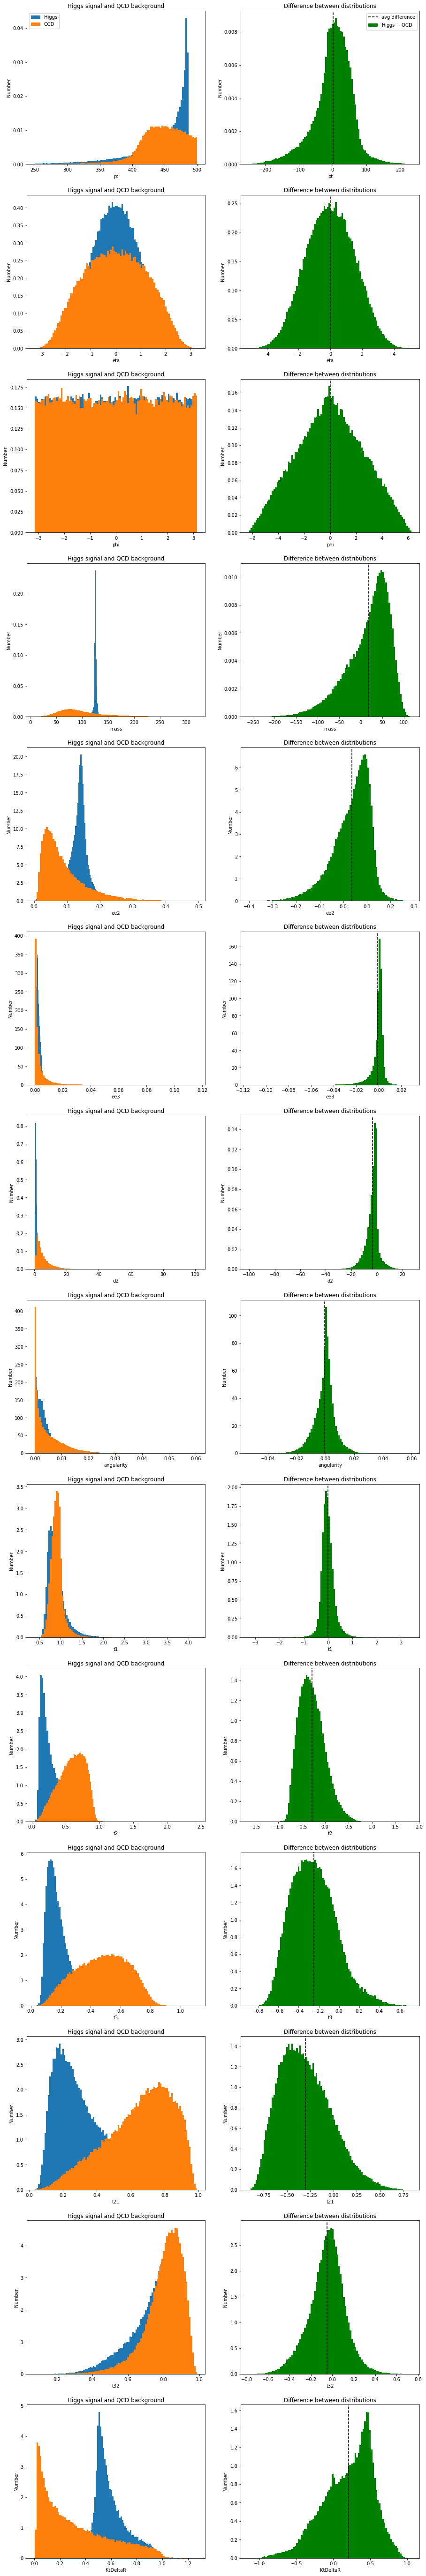

In [5]:
fig, ax = plt.subplots(14, 2, figsize=(15, 100))
n = 0

for key in higgs.keys():
    subtraction = higgs[key] - qcd[key]
    discrimination = np.mean(subtraction)
    
    ax[n, 0].hist(higgs[key], bins=100, density=True, label='Higgs')
    ax[n, 0].hist(qcd[key], bins=100, density=True, label='QCD')
    ax[n, 1].hist(subtraction, bins=100, density=True, color='g', label=r'Higgs $-$ QCD')
    ax[n, 1].axvline(discrimination, c='k', ls='--', label='avg difference')
    
    ax[n, 0].set_title('Higgs signal and QCD background')
    ax[n, 1].set_title('Difference between distributions')
    
    for m in range(2):
        ax[n, m].set_xlabel(str(key))
        ax[n, m].set_ylabel('Number')
    
    n += 1
    
ax[0, 0].legend(loc=0)
ax[0, 1].legend(loc=0);

Most of these features do not distinguish very powerfully between the two distributions. However, we can see that `mass` exhibits a nonzero average difference. And, as expected, `t21` differentiates powerfully between the Higgs and the background. We expected this because $\tau_{12}$ discriminates between decays based on whether they are two-pronged decays, like the decay of the Higgs into two bottom quarks. The background does not replicate this behavior well enough to escape our notice.

We also note that the property `ee2` (the two-point energy correlation function) is notably greater for the Higgs signals than the QCD background. Again, this is not surprising since this observable distinguishes two-pronged jets. As a result, `d2` is much lower for the Higgs than the QCD background, because $D_2^{\beta=1} \propto E_\text{CF2}^{-3}$.

There also appears to be a large enough discrepancy on average between the values of `KtDeltaR` for the Higgs signal and the QCD background in order to discriminate between them on the basis of this observable. Physically, this means that the jets due to Higgs events have a larger spatial extent on the detector than those due to background events.

In the future, we will return to these data and figure out how best to optimize our sensitivity to Higgs signals against the QCD background. It seems that the best course to do this is by applying selections to the parameters $\tau_{21}$ (the key `t21` in our data) and $D_2^{\beta=1}$ (the `d2` key). These quantities are on average very different when extracted from a Higgs jet as opposed to a jet containing bottom quark pairs due to parton scattering, as our plots show.

## References

* "Identification of boosted Higgs bosons decaying into *b*-quark pairs with the ATLAS detector at 13 TeV." Eur. Phys. J. C **79** (2019) 836.
* "Identifying Boosted Objects With $N$-Subjettiness." JHEP **03** (2011) 015.
* "Power Counting to Better Jet Observables." JHEP **12** (2014) 009.